In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline
pylab.rcParams['figure.figsize'] = (12, 8)
import warnings; warnings.filterwarnings("ignore")

import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import sys; sys.path.append('../')
from PDE_FIND import *
import scipy.io as sio
import itertools

import numpy as np
import pandas as pde_diff_new
from mpl_toolkits.mplot3d import Axes3D
from sympy import symbols

import sys; sys.path.append('../')
from PDE_FIND import *
from solvel0 import solvel0

import sys; sys.path.append('../../parametric-discovery/')
from best_subset import *
from frols import frols
from p_linear_regression import PLinearRegression
from r_pca import R_pca
from pde_diff_new import RPCA

import scipy.io as sio
from scipy.signal import savgol_filter
import itertools

from sklearn.preprocessing import normalize
from sklearn.linear_model import Ridge, BayesianRidge, LinearRegression as SkLinearRegression
from sklearn.base import BaseEstimator
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from abess.linear import LinearRegression
import pysindy as ps

from tqdm import trange
from os.path import join as join_path
FIGURE_EXPORT_PATH = "/Users/pongpisit/Documents/figure_export/"

from function_collections import msemse

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
Sklearn's version: 1.2.2
mrmr is not installed in the env you are using. This may cause an error in future if you try to use the (missing) lib.


In [2]:
# data = sio.loadmat("/Users/pongpisit/Desktop/research/examples/pde/datasets/gray_scott_acc_2d.mat")
data = sio.loadmat("../Datasets/reaction_diffusion_rudy.mat")

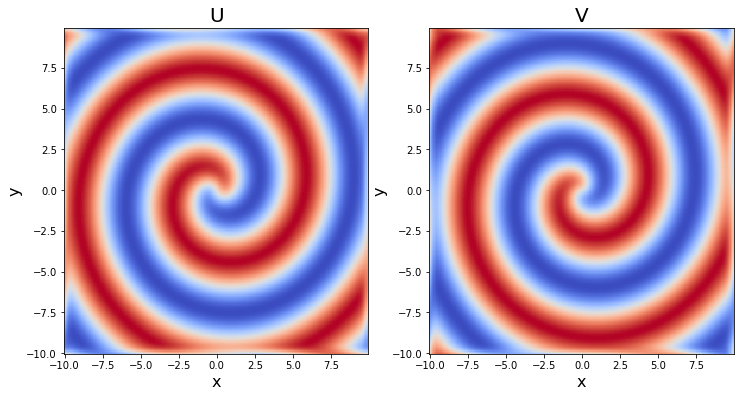

In [3]:
# t = data['tspan'][0,:]
# x = data['u_grid'][0,:]
# y = data['v_grid'][0,:]
# U = data['usol']
# V = data['vsol']

data = sio.loadmat('../Datasets/reaction_diffusion_2d_big.mat')
u_sol = real(data['u'])
v_sol = real(data['v'])
x = real(data['x'][0])
y = real(data['y'][0])
t = real(data['t'][:,0])

n = 512; issub = 2
if issub > 1:
    spatial_sub_indices = np.array([i for i in range(n) if i%issub==0])
    u_sol = u_sol[spatial_sub_indices, :, :][:, spatial_sub_indices, :]
    v_sol = v_sol[spatial_sub_indices, :, :][:, spatial_sub_indices, :]
    x = x[spatial_sub_indices]
    y = y[spatial_sub_indices]
m = 201; issub = 1
if issub > 1:
    time_sub_indices = np.array([i for i in range(m) if i%issub==0])
    u_sol = u_sol[:, :, time_sub_indices]
    v_sol = v_sol[:, :, time_sub_indices]
    t = t[time_sub_indices]

dt = t[1] - t[0]
dx = x[1] - x[0]
dy = y[1] - y[0]

pylab.rcParams['figure.figsize'] = (12, 6)
figure()
xx, yy = meshgrid(x, y)
subplot(1,2,1)
pcolor(xx,yy,u_sol[:,:,10],cmap='coolwarm')
title('U', fontsize = 20)
xlabel('x', fontsize = 16)
ylabel('y', fontsize = 16)
subplot(1,2,2)
pcolor(xx,yy,v_sol[:,:,10],cmap='coolwarm')
title('V', fontsize = 20)
xlabel('x', fontsize = 16)
ylabel('y', fontsize = 16)
pylab.rcParams['figure.figsize'] = (12, 8)

In [4]:
u = np.zeros((x.shape[0], y.shape[0], len(t), 2))
u[:, :, :, 0] = u_sol
u[:, :, :, 1] = v_sol

# Odd polynomial terms in (u, v), up to second order derivatives in (u, v)
library_functions = [
    lambda x: x,
#     lambda x: 1-x,
    lambda x: x * x * x,
    lambda x, y: x * y * y,
    lambda x, y: x * x * y,
]
library_function_names = [
    lambda x: x,
#     lambda x: '1-' + x,
    lambda x: x + x + x,
    lambda x, y: x + y + y,
    lambda x, y: x + x + y,
]

# Need to define the 2D spatial grid before calling the library
np.random.seed(100)
X, Y, T = np.meshgrid(x, y, t, indexing='ij')
XYT = np.transpose([X, Y, T], [1, 2, 3, 0])

In [5]:
# Need to increase the weak form mesh resolution a bit if data is noisy
weak_lib = ps.WeakPDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=2,
    spatiotemporal_grid=XYT,
    K=10000,
    is_uniform=True,
    periodic=False,
    include_interaction=True, 
    cache=True
)

### Noiseless ###
u_noisy = u.copy()

### Add noise ###
noise_lv = 10
domain_noise = 0.01*np.abs(noise_lv)*np.std(u_noisy)*np.random.randn(*u_noisy.shape)
u_noisy = u_noisy + domain_noise

In [6]:
denoise = True
if denoise:
    u_noisy = np.stack((savgol_filter(u_noisy[:, :, :, 0], window_length=41, polyorder=2), 
                        savgol_filter(u_noisy[:, :, :, 1], window_length=41, polyorder=2)), 
                       axis=-1)
    
#     import sgolay2
#     un = u_noisy[:, :, :, 0].T
#     vn = u_noisy[:, :, :, 1].T

#     div = 30
#     ws = max(un[0].shape)//div; po = 2
#     if ws%2 == 0: ws -=1

#     und = []
#     for i in trange(un.shape[0]):
#         und.append(sgolay2.SGolayFilter2(window_size=ws, poly_order=po)(un[i]))
#     und = np.stack(und, axis=0).T

#     vnd = []
#     for i in trange(vn.shape[0]):
#         vnd.append(sgolay2.SGolayFilter2(window_size=ws, poly_order=po)(vn[i]))
#     vnd = np.stack(vnd, axis=0).T

#     u_noisy = np.stack((und, vnd), axis=-1)
#     del und, vnd, und, vn

In [7]:
# thres = 1e-4 # 1e-3
# # optimizer = ps.STLSQ(threshold=thres, fit_intercept=True, normalize_columns=True, max_iter=100)
# optimizer = ps.SR3(threshold=thres, fit_intercept=True, normalize_columns=True, max_iter=100)
# # optimizer = ps.MIOSR(target_sparsity=2*7, fit_intercept=False, normalize_columns=True)

# model = ps.SINDy(feature_library=weak_lib, optimizer=optimizer, 
#                  cache=True, feature_names=['u', 'v'])
# model.fit(u_noisy, ensemble=False, library_ensemble=True)
# model.print()

# X_pre, y_pre = model.feature_library.cached_xp_full[0], model.cached_x_dot
# np.save("../RD_exp/IPI_output_files/X_pre_noise10_savgol41.npy", X_pre)
# np.save("../RD_exp/IPI_output_files/y_pre_noise10_savgol41.npy", y_pre)
# # np.save("../RD_exp/IPI_output_files/feature_names.npy", model.get_feature_names())

In [8]:
# Noiseless
# X_pre = np.load("../RD_exp/IPI_output_files/X_pre_clean.npy")
# y_pre = np.load("../RD_exp/IPI_output_files/y_pre_clean.npy")

# Noisy
X_pre = np.load("./IPI_output_files/X_pre_noise10.npy")
y_pre = np.load("./IPI_output_files/y_pre_noise10.npy")
if denoise:
    X_pre = np.load("./IPI_output_files/X_pre_noise10_savgol41.npy")
    y_pre = np.load("./IPI_output_files/y_pre_noise10_savgol41.npy")

u_pre, v_pre = y_pre[:, 0:1], y_pre[:, 1:2]; del y_pre
feature_names = np.load("./IPI_output_files/feature_names.npy")

In [9]:
solve_grb = solvel0(X_pre, u_pre, intercept=False, refine=True, max_complexity=10)

  0%|                                                                                                                              | 0/10 [00:00<?, ?it/s]

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-04


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.71it/s]


Call backward_refinement...


In [10]:
potential_indices = sum([Counter(e) for e in solve_grb])
potential_indices = sorted(potential_indices, key=potential_indices.get, reverse=True)[:15]
potential_indices = sorted(potential_indices)
potential_indices

[0, 1, 2, 3, 4, 5, 8, 9, 14, 40, 44, 49]

In [11]:
potential_feature_names = feature_names[potential_indices]
brute_solve = brute_force_all_subsets(X_pre[:, potential_indices], u_pre, max_support_size=10)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.42s/it]


In [12]:
map2pysindy = dict(zip([i for i in range(len(potential_indices))], potential_indices))

In [13]:
BICs = []
uncertainties = []
for effective_indices in brute_solve[-1]:
    effective_indices = [map2pysindy[ei] for ei in effective_indices]
    fit_res = sm.OLS(u_pre, X_pre[:, effective_indices]).fit()    
    BICs.append(fit_res.bic)
    uncertainties.append(sum(fit_res.bse))
BICs = np.array(BICs)
uncertainties = np.array(uncertainties)/min(uncertainties)

In [14]:
uncertainties

array([  1.        ,   2.39731344,   4.35252815,   6.75232921,
         8.89215848,  94.62508289,  66.60480058, 171.27083892,
       172.967509  , 252.54513331])

In [15]:
UBICs = BICs+log(len(u_pre))*uncertainties

7


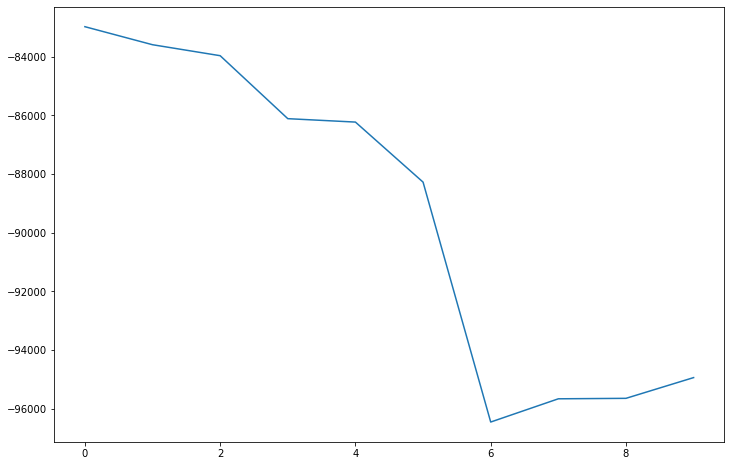

In [16]:
print(np.argmin(UBICs)+1)
plt.plot(UBICs); plt.show()
# plt.plot(UBICs[6:]); plt.show()

In [17]:
# w/o denoise
# array([-81969.36757484, -82571.52186569, -82919.29239281, -85085.774353  ,
#        -85181.58616869, -87305.3573137 , -96025.39827814, -95319.64182559,
#        -95311.73807398, -95277.489655  ])
# BICs[6]-BICs[5], max(BICs)-min(BICs) = (-8449.559157584343, 14789.840025737736)
# UBICs[6]-UBICs[5], max(UBICs)-min(UBICs) = (-8720.040964437503, 14056.030703301163)

# w/ denoise
# array([-82976.50944044, -83591.2407492 , -83965.36056973, -86111.9074522 ,
#        -86228.13093075, -88275.07386741, -96452.62454861, -95660.75983369,
#        -95644.80941487, -94937.84196144])
# BICs[6]-BICs[5], max(BICs)-min(BICs) = -8177.550681205699 13476.115108173122
# UBICs[6]-UBICs[5], max(UBICs)-min(UBICs) = -7919.474343799433 14278.148817722322

UBICs

array([-82976.50944044, -83591.2407492 , -83965.36056973, -86111.9074522 ,
       -86228.13093075, -88275.07386741, -96452.62454861, -95660.75983369,
       -95644.80941487, -94937.84196144])

In [18]:
print(UBICs[6]-UBICs[5], max(UBICs)-min(UBICs))
print(BICs[6]-BICs[5], max(BICs)-min(BICs))

-8177.550681205699 13476.115108173122
-7919.474343799433 14278.148817722322
